# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

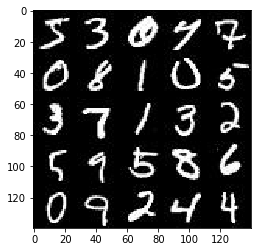

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

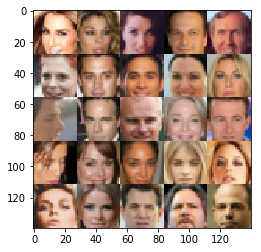

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
import numpy as np

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\site-packages\\ipykernel\\kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\ag

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [44]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        # Using Xavier initializer and dropout after reviewer suggestions
        # Ref: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
        # with a normal distribution
        
        x1 = tf.contrib.layers.conv2d(images, 64, 5, stride=2, padding='SAME', activation_fn=None, 
                                      weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = tf.layers.dropout(relu1, rate=0.2, training=True)
        # 14x14x64
        
        x2 = tf.contrib.layers.conv2d(relu1, 128, 5, stride=2, padding='SAME', activation_fn=None, 
                                      weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = tf.layers.dropout(relu2, rate=0.2, training=True)
        # 7x7x128
        
        x3 = tf.contrib.layers.conv2d(relu2, 256, 5, stride=2, padding='SAME', activation_fn=None, 
                                      weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = tf.layers.dropout(relu3, rate=0.2, training=True)
        # 4x4x256

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        # 1 FC layer
        logits = tf.contrib.layers.fully_connected(flat, 1, activation_fn=None, 
                                                   weights_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.contrib.layers.fully_connected(z, 2*2*1024, activation_fn=None, 
                                               weights_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x2 = tf.reshape(x1, (-1, 2, 2, 1024))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.layers.dropout(x2, rate=0.2, training=is_train)
        # 2x2x1024 now
        
        x3 = tf.contrib.layers.conv2d_transpose(x2, 512, 5, stride=2, padding='VALID', activation_fn=None, 
                                                weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.layers.dropout(x3, rate=0.2, training=is_train)
        # 7x7x512 now
        
        x4 = tf.contrib.layers.conv2d_transpose(x3, 256, 5, stride=2, padding='SAME', activation_fn=None, 
                                                weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #x4 = tf.layers.dropout(x4, rate=0.2, training=is_train)
        # 14x14x256 now
        
        x5 = tf.contrib.layers.conv2d_transpose(x4, 128, 5, stride=2, padding='SAME', activation_fn=None, 
                                                weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        #x5 = tf.layers.dropout(x5, rate=0.2, training=is_train)
        # 28x28x128 now
        
        # Output layer
        logits = tf.contrib.layers.conv2d_transpose(x5, out_channel_dim, 5, stride=1, padding='SAME', activation_fn=None, 
                                                weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [53]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    sample_z = np.random.uniform(-1, 1, size=[25, z_dim])
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # normalize
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)
                    gen_samples = sess.run(generator(input_z, data_shape[-1], False), feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)                
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.0516... Generator Loss: 0.0983
Epoch 1/2... Discriminator Loss: 3.2060... Generator Loss: 0.0658
Epoch 1/2... Discriminator Loss: 2.4411... Generator Loss: 0.1667
Epoch 1/2... Discriminator Loss: 3.5544... Generator Loss: 0.0490
Epoch 1/2... Discriminator Loss: 2.5866... Generator Loss: 0.1332
Epoch 1/2... Discriminator Loss: 2.7408... Generator Loss: 0.1173
Epoch 1/2... Discriminator Loss: 2.8209... Generator Loss: 0.1044
Epoch 1/2... Discriminator Loss: 2.7548... Generator Loss: 0.1092
Epoch 1/2... Discriminator Loss: 2.7047... Generator Loss: 0.1302
Epoch 1/2... Discriminator Loss: 2.6194... Generator Loss: 0.1408


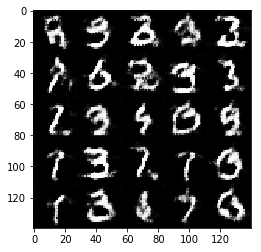

Epoch 1/2... Discriminator Loss: 2.8700... Generator Loss: 0.1111
Epoch 1/2... Discriminator Loss: 2.6746... Generator Loss: 0.1202
Epoch 1/2... Discriminator Loss: 2.5282... Generator Loss: 0.1450
Epoch 1/2... Discriminator Loss: 2.6705... Generator Loss: 0.1267
Epoch 1/2... Discriminator Loss: 3.0784... Generator Loss: 0.0793
Epoch 1/2... Discriminator Loss: 2.9524... Generator Loss: 0.0998
Epoch 1/2... Discriminator Loss: 2.5929... Generator Loss: 0.1301
Epoch 1/2... Discriminator Loss: 3.0021... Generator Loss: 0.0825
Epoch 1/2... Discriminator Loss: 2.8394... Generator Loss: 0.1056
Epoch 1/2... Discriminator Loss: 2.8191... Generator Loss: 0.1133


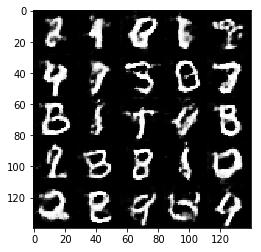

Epoch 1/2... Discriminator Loss: 2.5922... Generator Loss: 0.1250
Epoch 1/2... Discriminator Loss: 2.6637... Generator Loss: 0.1184
Epoch 1/2... Discriminator Loss: 2.5807... Generator Loss: 0.1315
Epoch 1/2... Discriminator Loss: 2.7995... Generator Loss: 0.1141
Epoch 1/2... Discriminator Loss: 3.0768... Generator Loss: 0.0800
Epoch 1/2... Discriminator Loss: 2.9387... Generator Loss: 0.0890
Epoch 1/2... Discriminator Loss: 2.6767... Generator Loss: 0.1149
Epoch 1/2... Discriminator Loss: 2.4956... Generator Loss: 0.1364
Epoch 1/2... Discriminator Loss: 2.4565... Generator Loss: 0.1492
Epoch 1/2... Discriminator Loss: 2.7706... Generator Loss: 0.1089


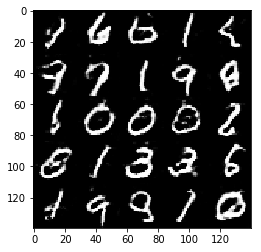

Epoch 1/2... Discriminator Loss: 2.4769... Generator Loss: 0.1424
Epoch 1/2... Discriminator Loss: 2.5222... Generator Loss: 0.1398
Epoch 1/2... Discriminator Loss: 3.0323... Generator Loss: 0.0797
Epoch 1/2... Discriminator Loss: 2.8648... Generator Loss: 0.0939
Epoch 1/2... Discriminator Loss: 3.1634... Generator Loss: 0.0757
Epoch 1/2... Discriminator Loss: 3.1337... Generator Loss: 0.0725
Epoch 1/2... Discriminator Loss: 2.7681... Generator Loss: 0.1063
Epoch 1/2... Discriminator Loss: 2.7942... Generator Loss: 0.0988
Epoch 1/2... Discriminator Loss: 2.9270... Generator Loss: 0.0910
Epoch 1/2... Discriminator Loss: 2.4647... Generator Loss: 0.1447


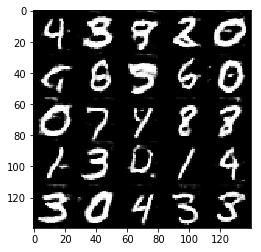

Epoch 1/2... Discriminator Loss: 2.7249... Generator Loss: 0.1091
Epoch 1/2... Discriminator Loss: 2.4656... Generator Loss: 0.1411
Epoch 1/2... Discriminator Loss: 3.1897... Generator Loss: 0.0755
Epoch 1/2... Discriminator Loss: 2.8172... Generator Loss: 0.1051
Epoch 1/2... Discriminator Loss: 3.0644... Generator Loss: 0.0773
Epoch 1/2... Discriminator Loss: 3.1294... Generator Loss: 0.0737
Epoch 2/2... Discriminator Loss: 3.2555... Generator Loss: 0.0647
Epoch 2/2... Discriminator Loss: 2.4867... Generator Loss: 0.1411
Epoch 2/2... Discriminator Loss: 2.9500... Generator Loss: 0.0913
Epoch 2/2... Discriminator Loss: 3.2451... Generator Loss: 0.0699


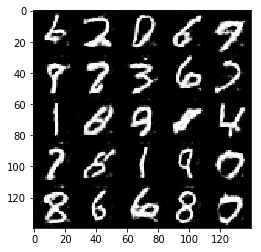

Epoch 2/2... Discriminator Loss: 3.1678... Generator Loss: 0.0710
Epoch 2/2... Discriminator Loss: 4.0350... Generator Loss: 0.0325
Epoch 2/2... Discriminator Loss: 3.3074... Generator Loss: 0.0618
Epoch 2/2... Discriminator Loss: 2.7364... Generator Loss: 0.1049
Epoch 2/2... Discriminator Loss: 2.9727... Generator Loss: 0.0892
Epoch 2/2... Discriminator Loss: 3.0049... Generator Loss: 0.0827
Epoch 2/2... Discriminator Loss: 2.9001... Generator Loss: 0.0944
Epoch 2/2... Discriminator Loss: 2.2139... Generator Loss: 0.2038
Epoch 2/2... Discriminator Loss: 3.1227... Generator Loss: 0.0773
Epoch 2/2... Discriminator Loss: 2.7420... Generator Loss: 0.1095


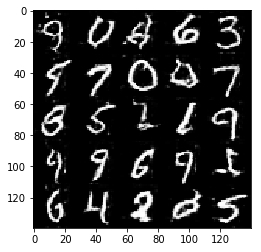

Epoch 2/2... Discriminator Loss: 2.7815... Generator Loss: 0.1048
Epoch 2/2... Discriminator Loss: 2.8559... Generator Loss: 0.0968
Epoch 2/2... Discriminator Loss: 2.8285... Generator Loss: 0.1014
Epoch 2/2... Discriminator Loss: 3.4047... Generator Loss: 0.0583
Epoch 2/2... Discriminator Loss: 2.8572... Generator Loss: 0.0995
Epoch 2/2... Discriminator Loss: 2.9917... Generator Loss: 0.0911
Epoch 2/2... Discriminator Loss: 2.1086... Generator Loss: 0.2187
Epoch 2/2... Discriminator Loss: 2.7581... Generator Loss: 0.1068
Epoch 2/2... Discriminator Loss: 3.3967... Generator Loss: 0.0559
Epoch 2/2... Discriminator Loss: 3.1625... Generator Loss: 0.0717


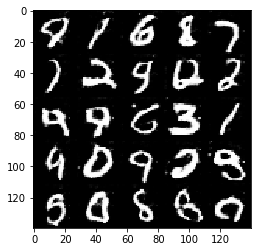

Epoch 2/2... Discriminator Loss: 3.1003... Generator Loss: 0.0775
Epoch 2/2... Discriminator Loss: 2.7540... Generator Loss: 0.1130
Epoch 2/2... Discriminator Loss: 3.5070... Generator Loss: 0.0509
Epoch 2/2... Discriminator Loss: 2.9860... Generator Loss: 0.0885
Epoch 2/2... Discriminator Loss: 3.2565... Generator Loss: 0.0663
Epoch 2/2... Discriminator Loss: 2.4719... Generator Loss: 0.1526
Epoch 2/2... Discriminator Loss: 2.8257... Generator Loss: 0.1008
Epoch 2/2... Discriminator Loss: 3.4671... Generator Loss: 0.0547
Epoch 2/2... Discriminator Loss: 3.1304... Generator Loss: 0.0743
Epoch 2/2... Discriminator Loss: 2.4050... Generator Loss: 0.1657


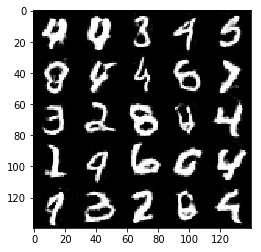

Epoch 2/2... Discriminator Loss: 2.7274... Generator Loss: 0.1228
Epoch 2/2... Discriminator Loss: 3.0828... Generator Loss: 0.0858
Epoch 2/2... Discriminator Loss: 3.1611... Generator Loss: 0.0732
Epoch 2/2... Discriminator Loss: 3.1983... Generator Loss: 0.0680
Epoch 2/2... Discriminator Loss: 2.5502... Generator Loss: 0.1398
Epoch 2/2... Discriminator Loss: 3.4085... Generator Loss: 0.0596
Epoch 2/2... Discriminator Loss: 3.3256... Generator Loss: 0.0612
Epoch 2/2... Discriminator Loss: 3.1588... Generator Loss: 0.0707
Epoch 2/2... Discriminator Loss: 3.3249... Generator Loss: 0.0636
Epoch 2/2... Discriminator Loss: 3.0507... Generator Loss: 0.0817


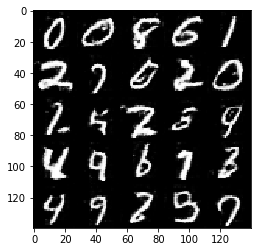

Epoch 2/2... Discriminator Loss: 3.5748... Generator Loss: 0.0474
Epoch 2/2... Discriminator Loss: 3.0473... Generator Loss: 0.0830
Epoch 2/2... Discriminator Loss: 3.7563... Generator Loss: 0.0423


In [54]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

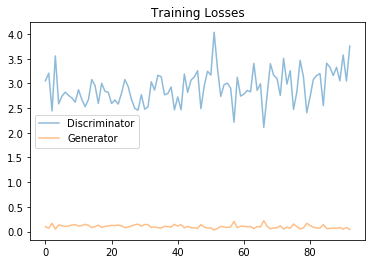

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 6.3126
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 11.9887
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 4.6418
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 5.1310
Epoch 1/1... Discriminator Loss: 3.3152... Generator Loss: 0.1571
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 2.4073
Epoch 1/1... Discriminator Loss: 2.3716... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 2.4408
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 3.0693
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 2.0477


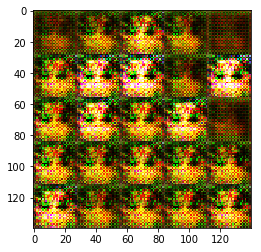

Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 3.4299
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 2.1623
Epoch 1/1... Discriminator Loss: 1.6695... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.6583
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 2.0835


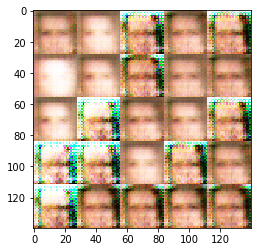

Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.2490
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 2.3283
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 2.0812
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.7277


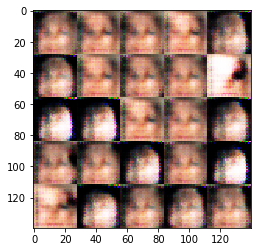

Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.5800
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.5520
Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 2.0410


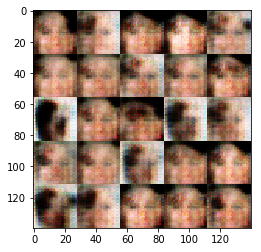

Epoch 1/1... Discriminator Loss: 1.8897... Generator Loss: 1.6801
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9184


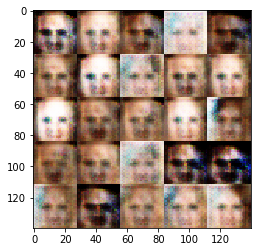

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 1.4334
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.1705


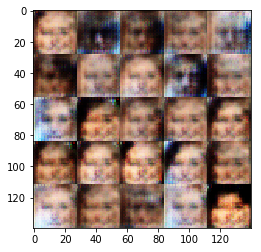

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.2316


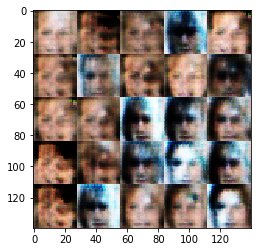

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.8127
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.6553... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 1.1230


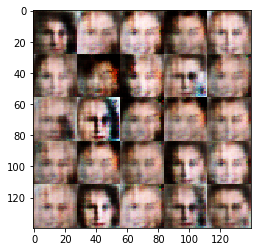

Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.8285
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.9970


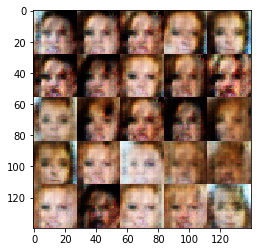

Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.3124


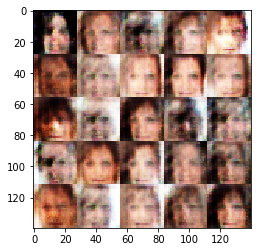

Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.0047


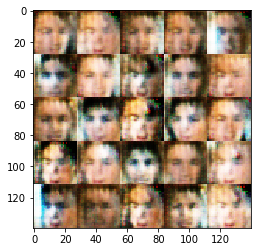

Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6316


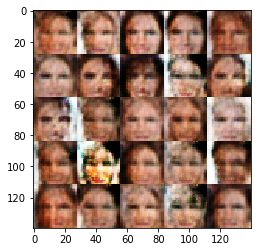

Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7231


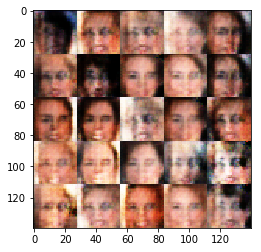

Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 1.3780
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.6696... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6661


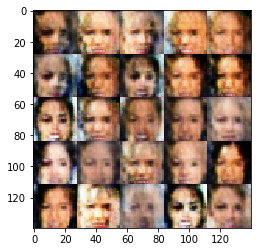

Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.9165


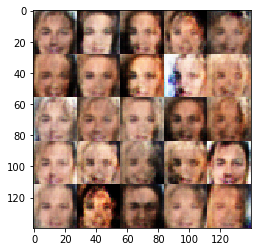

Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8630


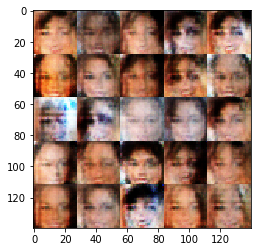

Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 1.2041


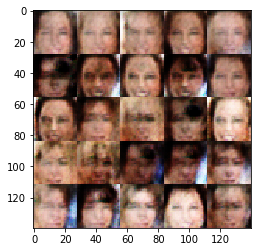

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7981


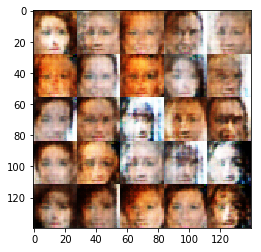

Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.9278


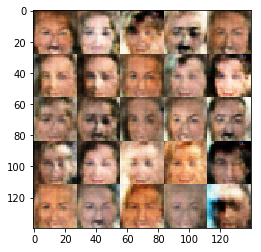

Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.9897


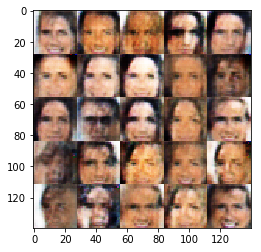

Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7392


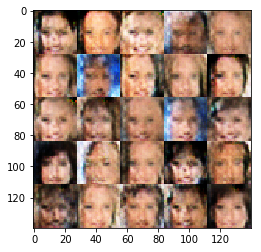

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.9494


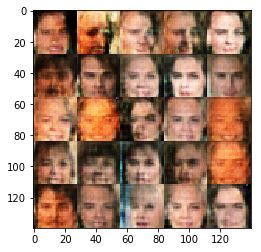

Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 1.1194


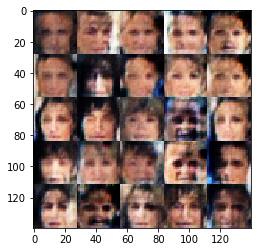

Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7935


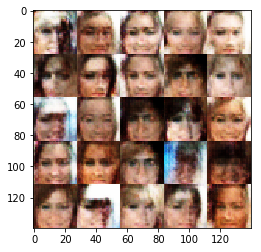

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8334


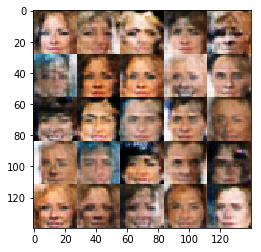

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8934


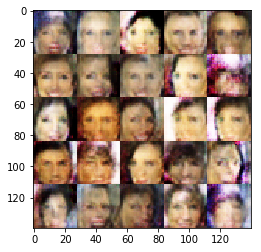

Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0411


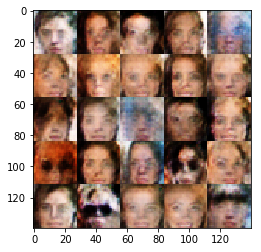

Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.0822


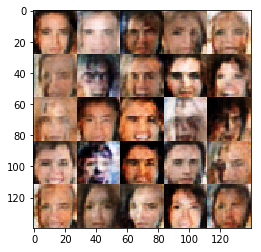

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6546


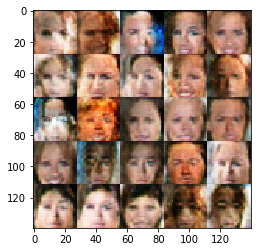

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7608


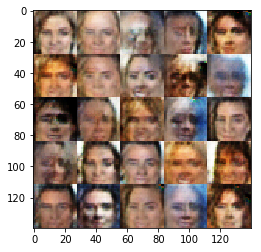

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 1.0669


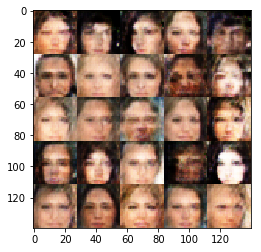

Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.9898


In [42]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

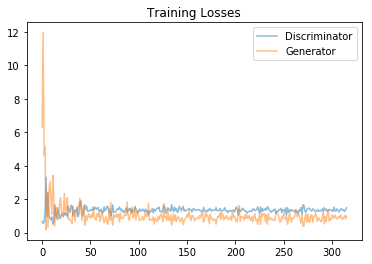

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.